В блокноте рассматриваются:
* Использование оценщика scikit-learn для повторной реализации простой линейной регрессии.
* Использование функции scatterplot библиотеки Seaborn для графического вывода данных и функции plot библиотеки Matplotlib для вывода регрессионной прямой.
* Использование значений угла наклона и точки пересечения, вычисленных оценщиком scikit-learn, для построения прогнозов.

In [27]:
import pandas as pd
nyc = pd.read_csv('https://raw.githubusercontent.com/dm-fedorov/ml/master/datasets/ave_hi_nyc_jan_1895-2018.csv')
nyc.head()

,Date,Value,Anomaly
0,189501,34.2,-3.2
1,189601,34.7,-2.7
2,189701,35.5,-1.9
3,189801,39.6,2.2
4,189901,36.4,-1.0


In [28]:
nyc.columns = ['Date', 'Temperature', 'Anomaly']

In [29]:
nyc.Date = nyc.Date.floordiv(100)

In [30]:
nyc.head(3)

,Date,Temperature,Anomaly
0,1895,34.2,-3.2
1,1896,34.7,-2.7
2,1897,35.5,-1.9


#### Разбиение данных для обучения и тестирования

В этом примере будет использоваться оценщик LinearRegression из sklearn.linear_model. По умолчанию он использует все числовые признаки в наборе данных, выполняя множественную линейную регрессию. Выполним простую линейную регрессию, используя один признак как независимую переменную. В наборе данных необходимо выбрать один признак (Date) из набора данных. 

При выборе одного столбца в двумерном DataFrame результат представляет собой одномерную коллекцию Series . Однако оценщики scikit-learn требуют, чтобы в качестве обучающих и тестовых данных использовались двумерные массивы (или двумерные структуры, сходные с массивами, например списки списков или коллекции pandas DataFrame). Чтобы использовать одномерные массивы с оценщиком, необходимо преобразовать их из одномерного массива с n элементами в двумерный массив c n строками и одним столбцом.

Как и прежде, данные будут разбиты на обучающий и тестовый наборы. И снова ключевой аргумент random_state используется для обеспечения воспроизводимости результатов:

In [31]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    nyc.Date.values.reshape(-1, 1), nyc.Temperature.values,
    random_state=11)

Выражение nyc.Date возвращает коллекцию Series для столбца Date, атрибут которой values возвращает массив NumPy со значениями коллекции. Для преобразования одномерного массива в двумерный вызовем метод reshape массива. Обычно в двух аргументах передается точное количество строк и столбцов, но первый аргумент -1 означает, что метод reshape должен вычислить количество строк на основании количества столбцов (1) и количества элементов (124) в массиве. Преобразованный массив содержит только один столбец, поэтому reshape делает вывод, что количество строк равно 124: разместить 124 элемента в один столбец можно, только распределив их
по 124 строкам. 

Для проверки пропорции обучающих тестовых данных (75% к 25%) запросим размеры X_train и X_test:

In [33]:
X_train.shape

(93, 1)

In [34]:
X_test.shape

(31, 1)

#### Обучение модели

В scikit-learn нет отдельного класса для простой линейной регрессии, потому что простая линейная регрессия является частным случаем множественной
линейной регрессии, поэтому мы воспользуемся оценщиком LinearRegression:

In [35]:
from sklearn.linear_model import LinearRegression

In [36]:
linear_regression = LinearRegression()

In [37]:
linear_regression.fit(X=X_train, y=y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

После обучения оценщика fit возвращает оценщика и IPython выводит строковое представление. Описания настроек по умолчанию доступны по [адресу](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html).

Чтобы найти регрессионную прямую с наилучшей подгонкой к данным, оценщик LinearRegression в итеративном режиме регулирует укол наклона и точку пересечения для минимизации суммы квадратов расстояний точек данных от линии.

После этого значения угла наклона и точки пересечения с осью, используемые в формуле y = mx + b, могут использоваться для прогнозирования. Угол наклона хранится в атрибуте coeff_ оценщика (m в формуле), а точка пересечения — в атрибуте intercept_ (b в формуле):

In [38]:
linear_regression.coef_

array([0.01939167])

In [39]:
linear_regression.intercept_

-0.30779820252658396

Позднее эти значения будут использованы для вывода регрессионной прямой и прогнозирования для конкретных дат.

#### Тестирование модели

Протестируем модель по данным из X_test и проверим прогнозы по набору данных, выводя прогнозируемые и ожидаемые значения для каждого пятого элемента:

In [40]:
predicted = linear_regression.predict(X_test)

In [41]:
expected = y_test

In [42]:
for p, e in zip(predicted[::5], expected[::5]):
    print(f'predicted: {p:.2f}, expected: {e:.2f}')

predicted: 37.86, expected: 31.70
predicted: 38.69, expected: 34.80
predicted: 37.00, expected: 39.40
predicted: 37.25, expected: 45.70
predicted: 38.05, expected: 32.30
predicted: 37.64, expected: 33.80
predicted: 36.94, expected: 39.70


#### Прогнозирование будущих температур и оценка прошлых температур

Воспользуемся полученными значениями угла наклона и точки пересечения для прогнозирования средней температуры в январе 2019 года, а также оценки
средней температуры в январе 1890 года. Лямбда-выражение в следующем фрагменте реализует формулу:

y = mx + b

Значение coef_ используется вместо m, а значение intercept_ — вместо b.

In [43]:
predict = (lambda x: linear_regression.coef_ * x + linear_regression.intercept_)

In [44]:
predict(2019)

array([38.84399018])

In [45]:
predict(1890)

array([36.34246432])

#### Визуализация набора данных с регрессионной прямой

Теперь построим диаграмму разброса данных при помощи функции scatterplot библиотеки Seaborn и функции plot библиотеки Matplotlib. 

Для вывода точек данных воспользуемся методом scatterplot с коллекцией DataFrame с именем nyc:

In [46]:
import seaborn as sns

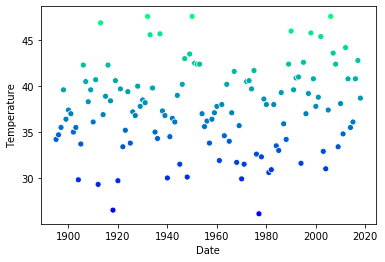

In [52]:
axes = sns.scatterplot(data=nyc, x='Date', y='Temperature',
                       hue='Temperature', palette='winter', legend=False)

#### Ключевые аргументы:

* data — коллекция DataFrame (nyc) с выводимыми данными;
* x и y — имена столбцов nyc, которые являются источником данных по осям x и y соответственно. В данном случае x содержит имя столбца 'Date' , а y — 'Temperature'. Соответствующие значения столбцов образуют пары координат x-y, наносимые на диаграмму;
* hue — столбец, данные которого используются для определения цветов точек ( 'Temperature' ). В нашем примере цвет особой роли не играет, но мы хотели сделать диаграмму более привлекательной;
* palette — цветовая карта Matplotlib, по которой выбираются цвета точек;
* legend=False — на диаграмме разброса данных не должны выводиться условные обозначения. По умолчанию используется значение True , но в нашем примере условные обозначения не нужны.

Изменим масштаб оси y, чтобы при выводе регрессионной прямой линейность отношения была более очевидной:

In [48]:
axes.set_ylim(10, 70)

(10, 70)

Перейдем к выводу регрессионной прямой. Начнем с создания массива, содержащего минимальные и максимальные значения даты из nyc.Date. Они станут координатами x начальной и конечной точек регрессионной прямой:

In [49]:
import numpy as np
x = np.array([min(nyc.Date.values), max(nyc.Date.values)])

В результате передачи predict массива x будет получен массив соответствующих прогнозируемых значений, которые будут использоваться в качестве координат y:

In [50]:
y = predict(x)

Наконец, функция plot библиотеки Matplotlib рисует линию по массивам x и y, представляющим координаты x и y точек соответственно:

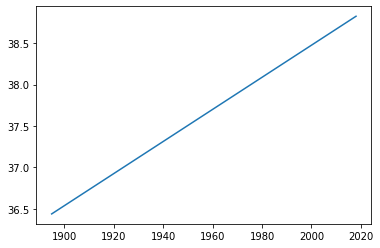

In [54]:
import matplotlib.pyplot as plt
line = plt.plot(x, y)

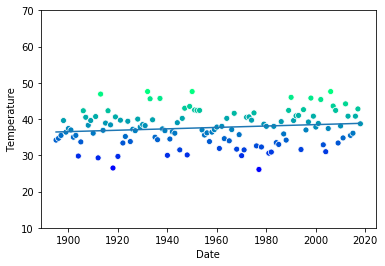

In [53]:
axes = sns.scatterplot(data=nyc, x='Date', y='Temperature',
                         hue='Temperature', palette='winter', legend=False)

axes.set_ylim(10, 70)

import numpy as np
x = np.array([min(nyc.Date.values), max(nyc.Date.values)])
y = predict(x)

import matplotlib.pyplot as plt 
line = plt.plot(x, y)

### Чрезмерная/недостаточная подгонка

При создании модели нужно в первую очередь стремиться к тому, чтобы эта модель выдавала точные прогнозы для данных, которые ей пока неизвестны. 

Две распространенные проблемы, препятствующие точному прогнозированию, — чрезмерная и недостаточная подгонка:
* Недостаточная подгонка происходит в том случае, если модель слишком проста для построения прогнозов на основании тренировочных данных. Например, линейная модель (скажем, простая линейная регрессия) используется в задаче, которая на самом деле требует нелинейной модели. Например, температуры существенно изменяются на протяжении четырех времен года. Если вы попытаетесь создать обобщенную модель, которая может прогнозировать температуры круглый год, модель простой линейной регрессии приведет к недостаточной подгонке данных.
* Чрезмерная подгонка происходит при излишней сложности модели. Крайний случай такого рода — модель, запоминающая свои обучающие данные. Такое решение приемлемо, если новые данные будут полностью совпадать с обучающими, но обычно это не так. При построении прогнозов на основании модели с чрезмерной подгонкой для новых данных, совпадающих с обучающими, будут сделаны идеально точные прогнозы, но такая модель не будет знать, что делать с данными, которые ей еще не встречались.